# Imports

In [1]:
# data import
import pickle

# data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
import matplotlib.pyplot as plt

#gaussian filter
from scipy.ndimage import gaussian_filter

In [2]:
pickle_path = ('../raw_data/clean-75-precinct.pickle')
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)

# Train & Test Df

## Cut Lat_Long Outliers (Outside 75th Precinct)

In [3]:
# max and min lat long for 75th precinct
lat_min, lat_max, lon_min, lon_max = (40.6218192717505, 40.6951504231971, -73.90404639808888, -73.83559344190869)

In [4]:
max_lat = df['latitude'] <= lat_max # is smaller or equal to max lat boundary
min_lat = df['latitude'] >= lat_min # is greater or equal to min lat boundary

max_lon = df['longitude'] <= lon_max # is smaller or equal to max lon boundary
min_lon = df['longitude'] >= lon_min # is greater or equal to min lon boundary

df = df[ max_lat & min_lat & max_lon & min_lon] # side note: excludes 125 wrong lat long

## Add 6h date

In [5]:
def round_six_hours(period):
    
    if period.hour < 6:
        period = period.replace(hour = 0)
        
    elif period.hour < 12 :
        period = period.replace(hour = 6)
        
    elif period.hour < 18 :
        period = period.replace(hour = 12)
        
    else:
        period = period.replace(hour = 18)
        
    return period

df['six_hour_date'] = df['period'].apply(lambda x: round_six_hours(x))

## Split dataframe

### Choosing Size of Train & Test Df

In [6]:
df.shape

(322104, 22)

In [7]:
year = df['period'].apply(lambda x: int(x.strftime('%Y')))

In [8]:
year.nunique() * 0.7 # choosing X_train size

9.1

### To be put into function:

In [9]:
inf_train = df['period'] >= datetime(2007, 1, 1, 0, 0, 0)

sup_train = df['period'] < datetime(2016, 1, 1, 0, 0, 0)

train_df = df[inf_train & sup_train] # if to be taken further add multiple val dfs, val in fit is not random

In [10]:
inf_test = df['period'] >= datetime(2016, 1, 1, 0, 0, 0)

sup_test = df['period'] <= datetime(2019, 10, 28, 0, 0, 0)

test_df = df[inf_test & sup_test]

### Check

In [11]:
train_df.shape, test_df.shape

((230922, 22), (87668, 22))

In [12]:
test_df.shape[0] / df.shape[0]

0.27217296276978864

# Matrix

In [13]:
def from_meters_to_steps(lat_meters, lon_meters):
    """
    gives the latitude and longitude step to use for the grid buckets
    lat_meters, lon_meters = lat/lon step
    """
    #Position, decimal degrees
    lat = 40
    lon = -73

    #Earth’s radius, sphere
    R=6378137

    #offsets in meters
    dn = lat_meters
    de = lon_meters

    #Coordinate offsets in radians
    dLat = dn/R
    dLon = de/(R*np.cos(np.pi*lat/180))

    #OffsetPosition, decimal degrees
    latO = dLat * 180/np.pi
    lonO = dLon * 180/np.pi 

    return latO, lonO

In [16]:
def from_coord_to_matrix_six(df, lat_meters, lon_meters):
        """
        outputs the 3D matrix of all coordinates for a given bucket height and width in meters
        """
        
        lat_meters = lat_meters
        lon_meters = lon_meters
        
        df = df.copy()
        
        #add 'time_index' column to df
        #ind = {time:index for index,time in enumerate(np.sort(df['period'].unique()))}
        #df['time_index'] = df['period'].map(ind)
        ind = {time: index for index, time in enumerate(np.sort(df['six_hour_date'].unique()))}
        df['time_index'] = df['six_hour_date'].map(ind)
        
        grid_offset = np.array([ -df['latitude'].max() , df['longitude'].min(), 0 ]) # Where do you start
        
        #from meters to lat/lon step
        lat_spacing, lon_spacing = from_meters_to_steps(lat_meters, lon_meters )
        
        grid_spacing = np.array([lat_spacing , lon_spacing, 1 ]) # What's the space you consider (euclidian here)
        
        #get points coordinates
        coords = np.array([( -lat, lon,t_ind) for lat, lon,t_ind \
                       in zip(df['latitude'],df['longitude'],df['time_index'])])

        # Convert point to index
        indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
        X = indexes[:,0]
        Y = indexes[:,1]
        Z = indexes[:,2]

        # virgin matrix
        # precinct distances:
        lat_min, lat_max, lon_max, lon_min = (40.6218192717505,
                                              40.6951504231971,
                                              -73.90404639808888,
                                              -73.83559344190869)
        lat_diff = lat_max - lat_min # distance in lat that makes up width of precinct 75
        lon_diff = lon_min - lon_max # distance in lon that makes up width of precinct 75
        
        # dim 1: distance of precinct in lat / lat_spacing
        a = np.zeros((np.round(lat_diff / lat_spacing).astype('int') + 1,
                     np.round(lon_diff / lon_spacing).astype('int') + 1,
                     Z.max() + 1))
    
        a[X, Y, Z] = 1

        lat_size = a.shape[1]
        lon_size = a.shape[2]
        img3D_non_conv = a

        return img3D_non_conv

In [17]:
img_six = from_coord_to_matrix_six(train_df, 15, 15)

In [18]:
def img_plot(img):
    
    fig, axes = plt.subplots(1, 4, figsize = (20, 10))

    max_lum = img.max()

    for i in range(4):
        axes[i].imshow(img[:, :, i], cmap = 'gray', vmin = 0, vmax = max_lum)

In [19]:
img_six.shape

(545, 390, 13146)

In [20]:
img_six_sample = img_six[:, :, 0:10]

In [21]:
img_six_sample.shape

(545, 390, 10)

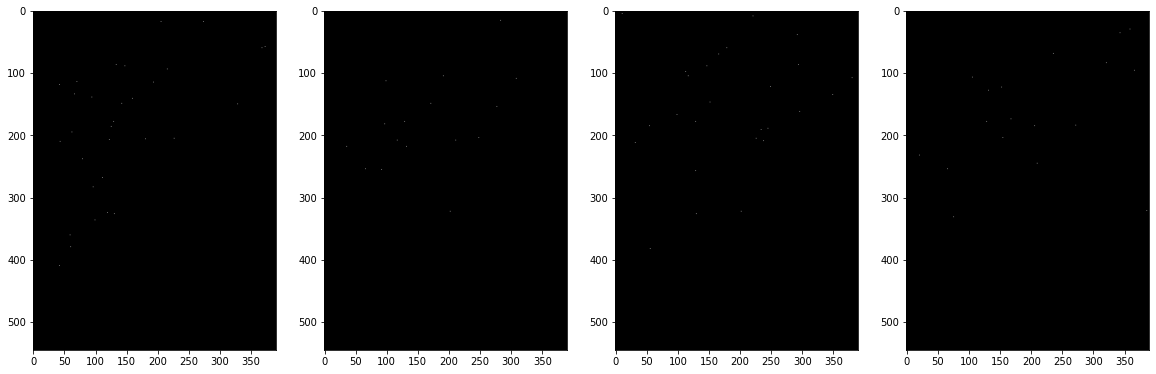

In [22]:
img_plot(img_six_sample)

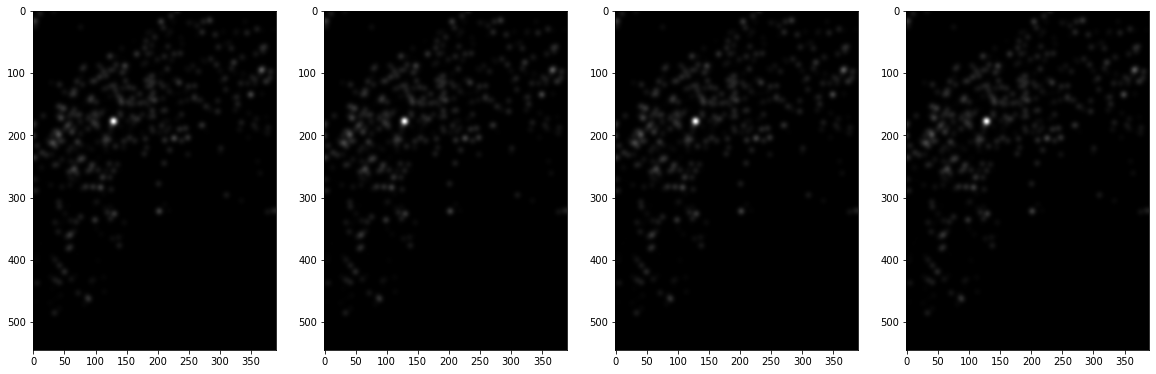

In [23]:
# (((120/15)/2), ((120/15)/2), (28/2))) = 4, 4, 14 (equ. to 120m stretch and week span)

img3D_conv_six = gaussian_filter(img_six, sigma = (4, 4, 14))

img_conv_sample = img3D_conv_six[:, :, 0:10]

img_plot(img_conv_sample)

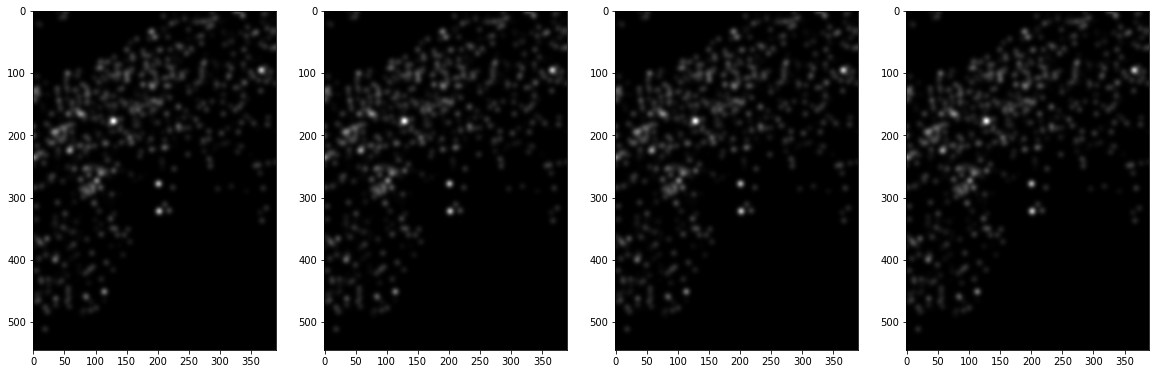

In [24]:
img_conv_sample_2 = img3D_conv_six[:, :, 90:100]

img_plot(img_conv_sample_2)

## Stacking

In [38]:
def stacking(img3D, window, lat_step, lon_step, time_step):
    
    grid_offset = np.array([0,0,0]) # Where do you start
    
    #new steps from precise grid
    grid_spacing = np.array([lat_step , lon_step, time_step]) 
    #get points coordinates
    coords = np.argwhere(window)
    flat = window.flatten()
    values = flat[flat !=0]
    
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    X = indexes[:,0] 
    Y = indexes[:,1] 
    Z = indexes[:,2]
    
    #virgin matrix
    a = np.zeros((int(img3D.shape[0]/lat_step)+2, int(img3D.shape[1]/lon_step)+2,Z.max()+1))  
    
    for i in range(len(indexes)):
        if a[X[i], Y[i], Z[i]] == 0:
            a[X[i], Y[i], Z[i]] = values[i]
        else:
            a[X[i], Y[i], Z[i]] += values[i]
                        
    return a

In [45]:
def get_observation_target(img3D,
                           obs_timeframe,obs_lat,obs_lon, obs_time,
                           target_timeframe,  tar_lat,tar_lon, tar_time):
    '''
    output an observation of x_length consecutive images and the y_length next images as the target
    obs_step, obs_timeframe, target_step, target_timeframe : unit = hours
    '''
    #function from raw to hours
    print('creating obs')
    
    raw_z = 28
    
    # add a week and 6h in between (depends on gaussian sigma)
    sample_length = obs_timeframe + (raw_z + 1) + target_timeframe
    # 56 + 28 + 2 = length of observation
    # length of observation = obs_timeframe + (sigma_time + 1) + target_timeframe
    
    # observation = position : position + length of observation
    # X = observation[0] : observation[0] + obs_timeframe
    # y = observation[-1] - target_timeframe : observation[-1]
    
    # finds starting position
    position = np.random.randint(0, img3D.shape[2] - sample_length)
    
    # samples in train and test dfs
    subsample = img3D[:, :, position : position + sample_length]
    
    # divide the subsample in X and y
    observations = subsample[:, :, : obs_timeframe]
    targets = subsample[:, :, - target_timeframe : ]
    
    observation = stacking(img3D, observations, obs_lat, obs_lon, obs_time) #get stacked hours for all images
    print(observation.shape)
    #print (targets.shape)
    
    target = stacking(img3D, targets,  tar_lat, tar_lon, tar_time )
    print(target.shape)
    return observation, target

In [46]:
def get_X_y(img3D_conv, nb_observations, obs_tf,obs_lat,obs_lon, obs_time,
                tar_tf, tar_lat,tar_lon, tar_time):
    '''
    outputs n observations and their associated targets
    '''
    X = []
    y = []
    
    for n in range(nb_observations):
        X_subsample, y_subsample = get_observation_target(img3D_conv,
                                       obs_tf,obs_lat,obs_lon, obs_time,
                                       tar_tf,  tar_lat,tar_lon, tar_time)
        X.append(X_subsample)
        y.append(y_subsample)
        
    X = np.array(X)
    y = np.array(y)

    del X_subsample, y_subsample, n
    
    return X, y

In [47]:
# grid has buckets of 15m * 15m, each image is 6h
# 28 * 6h is 1 week
# stacking has to be inferior to gaussian so model can learn from gaussian filter

obs_lon = 4 # 4 * 15m = 60m
obs_lat = 4 # 4 * 15m = 60m
obs_time = 4 # 24h - each obs of X is 14 images (each image is 24h)
obs_tf = 56 # 4 (slots of 6h) * 14 days = 56 * 6 or 2 weeks (represents two weeks, where each img is 6h)
tar_lon =  8 # 8 * 15m = 120m
tar_lat = 10 # 10 * 15m = 150m
tar_time = 2 # each image is 12h - output: one image of 12h
tar_tf = 8 # 4 * 6h = 12h
nb_observations = 20

X, y = get_X_y(img3D_conv_six,
               nb_observations,
               obs_tf, obs_lat, obs_lon, obs_time,
               tar_tf, tar_lat,tar_lon, tar_time)

creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)
creating obs
(138, 99, 15)
(56, 50, 1)


In [48]:
X.shape, y.shape # 68, 22 size that worked

((20, 138, 99, 15), (20, 56, 50, 1))

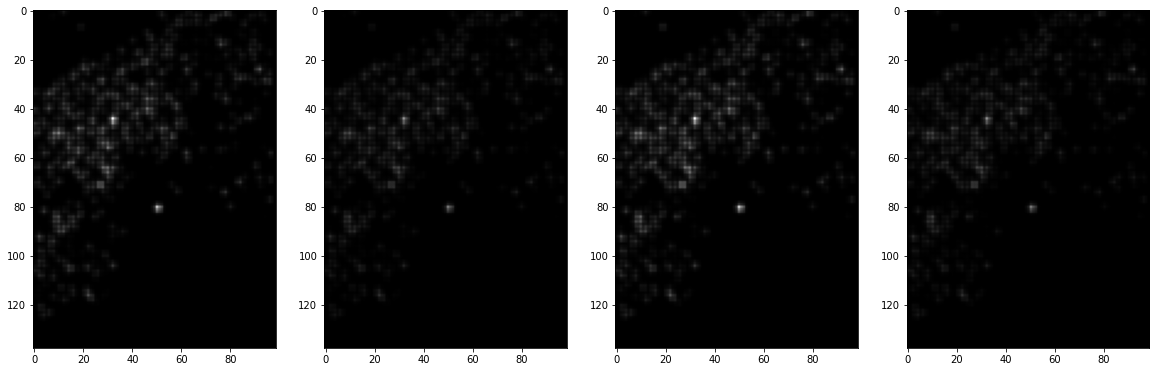

In [49]:
X_sample = X[0, :, :, 10: 15]

img_plot(X_sample)

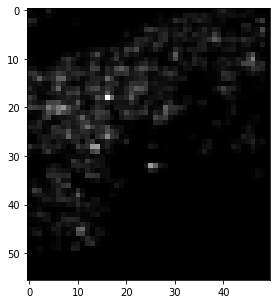

In [50]:
plt.figure(figsize = (5, 5))

plt.imshow(y[0, :, :, :], cmap='gray'); # take y two weeks later ? data leakage risk (X contains y points)